In [1]:
from cxai import factory, inspector, constants, drsa
from cxai import utils as putils

from matplotlib import pyplot as plt

from tqdm import tqdm

import numpy as np

# Introduction


In `./disentangled-explanations.ipynb`, we use these two sets of vectors (`arr_act` and `arr_ctx`) to learn the PRCA basis. These vectors are pre-extracted from a large set of training images from Class Basketball.


This notebook demonstrates how to extract such vectors from a set of images; for the sake of demonstration, we use only four images.

## Preparing Model and Explainer

In [2]:
DATA_DIR = putils.parent_dir(constants.PACKAGE_DIR) / "data"

ARCH = "torchvision-vgg16-imagenet"

NSID = "n02802426"

LABEL = putils.imagenet.get_index_from_imagenet_id(NSID)

NSID, LABEL

('n02802426', 430)

In [3]:
model, (rc_transform, input_transform) = factory.make_model(ARCH)

In [4]:
# here, we demonstrates with 4 training images.
# the pre-extracted arr_act aand arr_ctx are from 500 training images of the class basket ball.
training_images = list(map(
    lambda i: putils.load_image(DATA_DIR / "images" / f"img-{i}.jpg"),
    range(4)
))

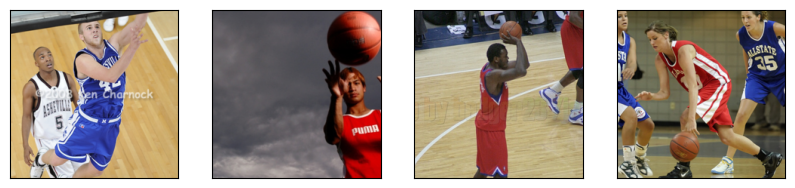

In [5]:
def visualize_images():
    
    ncols = len(training_images)
    
    plt.figure(figsize=(2.5*ncols, 2.5))
    
    for i in range(ncols):
        plt.subplot(1, ncols, i+1)
        putils.viz.imshow(
            rc_transform(training_images[i])
        )
visualize_images()

In [6]:
# instantiate an LRP-VGG16 explainer
explainer = factory.make_explainer("lrp", model)

# Extraction

In [7]:
def subsample_act_and_ctx(act, ctx, num_locations_selected=10):
    # Let
    # - `wh` be the number of spatial locations
    # - `n` be `num_locations_selected`
    # - `d` number of channels
    # The function selects the `d`-dimensional activation and context vectors of `n` random spatial locations from all `wh` locations.
    # Then, it returns each group of the vectors as a (n, d) matrix.

    assert len(act.shape) == 4 and act.shape == ctx.shape
    
    act = act.squeeze().detach().cpu().numpy()
    ctx = ctx.squeeze().detach().cpu().numpy()

    np.testing.assert_allclose(act.shape, ctx.shape)

    dim_c, dim_h, dim_w = act.shape

    total_spatial_locations = dim_h * dim_w

    # remarks:
    # - we assume the tensor in (c, h, w) where c is the dimension of channels;
    # - seed should be set outside.
    selected_locations = np.random.permutation(total_spatial_locations)[
        :num_locations_selected
    ]

    act_flatten = act.reshape((dim_c, total_spatial_locations))
    ctx_flatten = ctx.reshape((dim_c, total_spatial_locations))

    act_flatten_selected = act_flatten[:, selected_locations]
    ctx_flatten_selected = ctx_flatten[:, selected_locations]

    assert (
        act_flatten_selected.shape[1]
        == ctx_flatten_selected.shape[1]
        == num_locations_selected
    )

    return act_flatten_selected.T, ctx_flatten_selected.T, selected_locations

In [8]:
def extract_activation_and_context(
    layer, 
    num_locations_selected=20, # this is a hyperparameter.
    seed=1
):
    
    np.random.seed(1)
    
    arr_act, arr_ctx = [], []
    
    print(f"Extracting `activation` and `context` vectors from layer={layer} (subsampled to {num_locations_selected} locations)")
        
    for ix, img in enumerate(training_images):
        print(f"------ [Image {ix}] ------")
        
        x = input_transform(img)
        
        layer_act, layer_ctx = explainer.get_intermediate_activation_and_context(
            layer=layer,
            x=x,
            label=LABEL
        )
        
        # shape of layer_act, layer_ctx: [1, d, h, w]
        assert layer_act.shape == layer_ctx.shape
        assert len(layer_act.shape) == 4
        
        print(f">            act.shape={tuple(layer_act.shape)}")
        
        layer_act_subsampled, layer_ctx_subsampled, _ = subsample_act_and_ctx(
            layer_act,
            layer_ctx,
            num_locations_selected=num_locations_selected
        )
        
        print(f"> act_subsampled.shape={layer_act_subsampled.shape}")

        arr_act.append(layer_act_subsampled)
        arr_ctx.append(layer_ctx_subsampled)
        
    
    arr_act = np.concatenate(arr_act)
    arr_ctx = np.concatenate(arr_ctx)
    
    assert arr_act.shape[0] == len(training_images) * num_locations_selected
    
    return arr_act, arr_ctx
 
arr_act, arr_ctx = extract_activation_and_context("conv4_3")

Extracting `activation` and `context` vectors from layer=conv4_3 (subsampled to 20 locations)
------ [Image 0] ------


/home/pat/.cache/pypoetry/virtualenvs/concept-xai-TCwLCSir-py3.9/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


>            act.shape=(1, 512, 28, 28)
> act_subsampled.shape=(20, 512)
------ [Image 1] ------
>            act.shape=(1, 512, 28, 28)
> act_subsampled.shape=(20, 512)
------ [Image 2] ------
>            act.shape=(1, 512, 28, 28)
> act_subsampled.shape=(20, 512)
------ [Image 3] ------
>            act.shape=(1, 512, 28, 28)
> act_subsampled.shape=(20, 512)


In [9]:
# shape: [total images x num_locations, d]
arr_act.shape, arr_ctx.shape

((80, 512), (80, 512))